In [1]:
import  os, sys
import  matplotlib.pyplot as plt
import yaml
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
sys.path.append('../')  # Add parent dir to path

import hardware

In [2]:
def mjd_to_hours(mjd):
    seconds_per_day = 86400  # 24 hours * 60 minutes * 60 seconds
    mjd_epoch = 2400000.5  # JD of MJD
    
    # MJD --> JD
    jd = mjd + mjd_epoch
    
    # JD --> hrs since start
    hours_since_start = (jd - jd.iloc[0]) * 24
    
    return hours_since_start


In [3]:
config = yaml.safe_load(open('../config/devices.yml','r'))
config = config['battery']
config['initial']=config['capacity']*0.99 # start with full 
print(config)

{'initial': 238.58010000000002, 'capacity': 240.99, 'charge_unit': 'Ah', 'capacity_fade': 0.0063, 'self_discharge': 0.01, 'VOC_table': 'data/hardware/battery/battery_VOC.dat', 'VOC_table_cols': 'SOC VOC@0 R@0 VOC@20 R@20 VOC@40 R@40'}


## Compare with new model (Night1) 7/24/24

In [5]:
night1_coldpow = pd.read_csv('Night1_Cold Power_354hrEclipse_240724.csv',delimiter=',', header= None)
night1_coldpow = night1_coldpow.T ## flips
night1_coldpow.columns = night1_coldpow.iloc[0] ## sets col
night1_coldpow = night1_coldpow.drop(0) ## reindex
night1_coldpow = night1_coldpow[0:2362] ## end of data
night1_coldpow['tot_sum'] = night1_coldpow['LuSEE Q Total_SUM'].astype(float) + night1_coldpow['POHTR_BATT'].astype(float) + night1_coldpow['Radio_XMIT'].astype(float) 
night1_coldpow=night1_coldpow.loc[:, ~night1_coldpow.columns.duplicated()] ## remove duplicate columns
night1_coldpow['Nodes/Times'] = night1_coldpow['Nodes/Times'].astype(float)

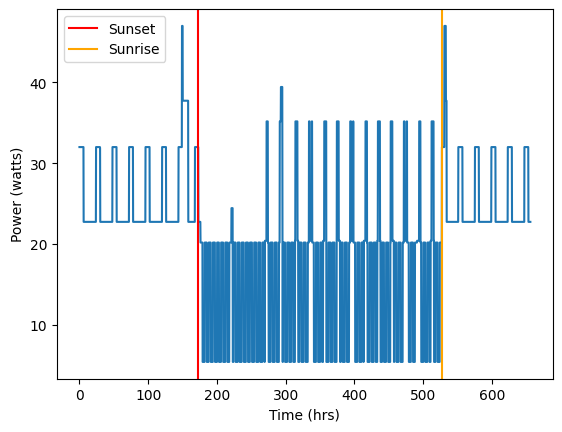

In [6]:
plt.plot(night1_coldpow['Nodes/Times'], night1_coldpow['tot_sum'])
plt.xlabel('Time (hrs)')
plt.ylabel('Power (watts)')
plt.axvline(x = 172.7, color = 'red',label='Sunset')
plt.axvline(x = 527.2, color = 'orange',label='Sunrise')
plt.legend()

In [7]:
# load in solar panels
sol_pvt = pd.read_csv('sol_pow_RevA.csv',delimiter=',') ## loading in solar power data
sol_pvt['sol_hrs'] = mjd_to_hours(sol_pvt['Time (mjd)'])
sol_pvt= sol_pvt[sol_pvt['sol_hrs'] < max(night1_coldpow['Nodes/Times'])]

print(sol_pvt)
# interp1d lunar power data to the time points of thermal model
interp_func = interp1d(sol_pvt['sol_hrs'], sol_pvt['Solar power (watts)'], fill_value='extrapolate')
lunar_pow_interp = interp_func(pd.to_numeric(night1_coldpow['Nodes/Times']))
print(len(lunar_pow_interp))

      Unnamed: 0    Time (mjd)  Solar power (watts)   Solar X   Solar Y  \
0              0  61050.833333             0.000000  0.999646 -0.025699   
1              1  61050.843750             0.000000  0.999681 -0.024805   
2              2  61050.854167             0.000000  0.999710 -0.023910   
3              3  61050.864583             0.000000  0.999735 -0.023016   
4              4  61050.875000            75.753746  0.999755 -0.022122   
...          ...           ...                  ...       ...       ...   
2619        2619  61078.114583             0.000000  0.872982 -0.205602   
2620        2620  61078.125000             0.000000  0.874058 -0.204819   
2621        2621  61078.135417             0.000000  0.875128 -0.204036   
2622        2622  61078.145833             0.000000  0.876195 -0.203251   
2623        2623  61078.156250             0.000000  0.877257 -0.202465   

       Solar Z  Panel E Temp  Panel W Temp  Panel Top Temp  \
0    -0.006858   -177.456373   -177.4

In [8]:
sunset = 172.7 
sunrise = 527.2

In [9]:
################ begin at sunset  ##################################
night1_coldpow = night1_coldpow[night1_coldpow['Nodes/Times'] > sunset]

In [10]:
colors = ['b','g','k']
T= 0
plt.figure()
B = hardware.Battery(config, verbose=False)
B.set_temperature(T)
energy = 0
deltaT_list= []
soc_values = []
power_values = []
time_list = []
solar_applied = False
solar_index = 0 
sol_cont = []
cond_heater = 0 ## 3.27  if heater
for i in range(len(night1_coldpow['Nodes/Times']) - 1):
    deltaT =  3600*(night1_coldpow['Nodes/Times'].iloc[i+1] -night1_coldpow['Nodes/Times'].iloc[i])
    deltaT_list.append(deltaT)
    P = night1_coldpow['tot_sum'].iloc[i] 
    if not solar_applied:
        sol_cont.append(0)
        power_values.append(P)
        B.apply_power(-P,deltaT) # discharge at 1W
        B.apply_age(deltaT)
        energy += deltaT*P
        soc_values.append(B.SOC())
   
    if night1_coldpow['Nodes/Times'].iloc[i] >= sunrise and not solar_applied:
       while solar_index <= (len(night1_coldpow['Nodes/Times'])-i): 
           ### discharging
           deltaT =  3600*(night1_coldpow['Nodes/Times'].iloc[solar_index+1] - night1_coldpow['Nodes/Times'].iloc[solar_index])
           P =night1_coldpow['tot_sum'].iloc[solar_index+i] 
           B.apply_power(-P,deltaT) 
           power_values.append(P)

           ### charging
           P_add = sol_pvt['Solar power (watts)'].iloc[solar_index]
           B.apply_power(P_add, deltaT)
           solar_index += 1
           energy += deltaT*(P_add-P)
           sol_cont.append(P_add)
           soc_values.append(B.SOC())
           if len(soc_values) > len(night1_coldpow['Nodes/Times']) - 1:
                   break
           solar_applied = True


<Figure size 640x480 with 0 Axes>

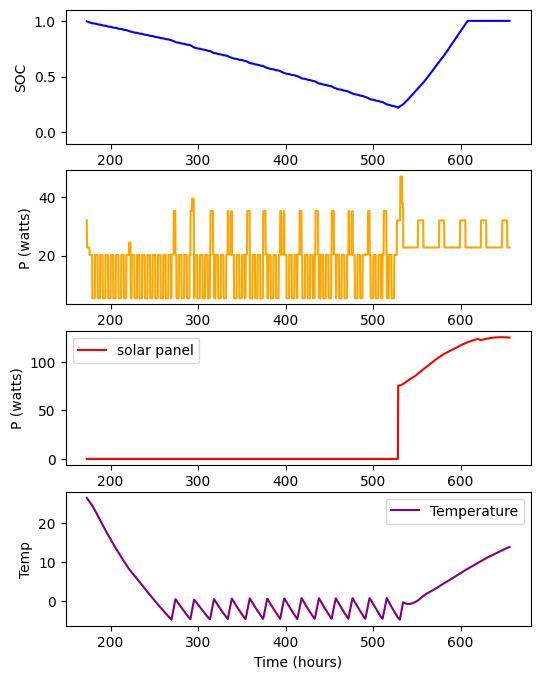

In [11]:
fig =plt.figure(figsize=(6, 8))
plt.subplot(4, 1, 1)
plt.plot(night1_coldpow['Nodes/Times'], soc_values, color ='blue' ,label=T)
plt.ylim(-0.1,1.1)
plt.ylabel('SOC')
plt.subplot(4, 1, 2)
plt.plot(night1_coldpow['Nodes/Times'],power_values, color = 'orange' ,label=T )
plt.ylabel('P (watts)')
plt.subplot(4, 1, 3)
plt.plot(night1_coldpow['Nodes/Times'], sol_cont, color = 'red',label='solar panel')
plt.ylabel('P (watts)')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(night1_coldpow['Nodes/Times'],night1_coldpow['Battery_AVG'], color = 'purple',label='Temperature')
plt.ylabel('Temp')
plt.xlabel('Time (hours)')
plt.legend()

 
plt.show() 

In [14]:
## IF wanting to save file locally
csv1 = {'Time_therm':night1_coldpow['Nodes/Times'], 'SOC':soc_values,'Power_hardware':power_values,'Power_sol_pan':sol_cont,
        'Temperature':night1_coldpow['Battery_AVG']}
df = pd.DataFrame.from_dict(csv1)
pd.DataFrame.to_csv(df,'Night1_t_soc_RevB.csv')

In [13]:
## IF wanting to save file locally
csv2 = {'Time_opsim':sol_pvt['sol_hrs'],'Solar power (watts)': sol_pvt['Solar power (watts)'],'Solar X':sol_pvt['Solar X'], 'Solar Y':sol_pvt['Solar Y'],'Solar Z':sol_pvt['Solar Z'], 'Panel E Temp': sol_pvt['Panel E Temp'], 'Panel W Temp': sol_pvt['Panel W Temp'],
          'Panel Top Temp': sol_pvt['Panel Top Temp'],'Panel E Efficiency':sol_pvt['Panel E Efficiency'],'Panel W Efficiency':sol_pvt['Panel W Efficiency'], 'Panel Top Efficiency':sol_pvt['Panel Top Efficiency']}  
df = pd.DataFrame.from_dict(csv2)
pd.DataFrame.to_csv(df,'Night1_xyz_panelT_pveff.csv')